In [1]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# import slayer from lava-dl
from tqdm import tqdm
from lava.lib.dl.decolle.loss import DECOLLELoss
from lava.lib.dl.decolle.utils import DECOLLEAssistant
import lava 
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
import IPython.display as display
from matplotlib import animation
import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import read_csv

# SNN-MLP-Multivariate-BOOTSTRAP-Network-ANN-SNN-LAVA

In [15]:
# Read the CSV file, parse the 'date' column with the specified format, and set it as the index
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'],index_col='date')
dataset = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
#dataset.info() 
dataset = dataset.astype(np.float64)
dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# load dataset
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
## Reshape for Conv4d
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ))
#train_y = train_y.reshape((train_y.shape[0], 1, 1,1))
#test_y = test_y.reshape((test_y.shape[0], 1, 1,1))
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     :0.5,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params,
                 #'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
            }

        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Dense(neuron_params_norm, 18, 32),
                bootstrap.block.cuba.Dense(neuron_params_norm,32, 32),
                bootstrap.block.cuba.Affine(neuron_params, 32, 1),
            ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
            #print("Input shape:", x.shape)
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        x = x.reshape(N, -1, x.shape[-1])
        #print("Input shape:", x.shape)
        sparsity_list = []  # List to store the sparsity values

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)
        
        return x
    # Instantiate Network, Optimizer, DataSet and DataLoader
batch  =64# batch size
lr     = 0.001 # leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs =60 # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones
trained_folder = 'Trained'
logs_folder = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)
#device = torch.device('cuda')
device = torch.device('cpu')
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones
# Dataset and dataLoader instances.
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader, 0):
        net.train()
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        #prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        #stats.training.correct_samples += torch.sum( prediction == label ).data.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Here we compute the event rate
            
            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()# This line is changed to average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)
            #loss = F.mse_loss(rate, label.to(device))
            #prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
        #stats.testing.correct_samples += torch.sum( prediction == label ).data.item()

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Now that we're sure that all entries have the same length, calculate the mean
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)
  
    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')


[[0.18387909 0.41533546 0.81315346 ... 0.21388889 0.09433962 0.        ]
 [0.17632242 0.41533546 0.82833052 ... 0.25       0.11320755 0.        ]
 [0.17128463 0.41214058 0.83552558 ... 0.275      0.16981132 0.        ]
 ...
 [0.39042821 0.73801917 0.94738617 ... 0.07222222 0.1509434  0.        ]
 [0.38790932 0.73482428 0.94749859 ... 0.09444444 0.11320755 0.        ]
 [0.38539043 0.7284345  0.93715571 ... 0.13333333 0.11320755 0.        ]]
[0.         0.         0.09980989 ... 0.         0.         0.        ]
(21024, 18) (21024,) (5253, 18) (5253,)
torch.Size([21024, 18]) torch.Size([21024]) torch.Size([5253, 18]) torch.Size([5253])
torch.Size([21024, 18, 1, 1])
torch.Size([5253, 18, 1, 1])
torch.Size([21024])
torch.Size([5253])
                                                                                                                                                             
Mode: SNN
[Epoch  0/60]
SNN Testing: loss =     0.02798                          accuracy = 0.00000 
 

#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 53.0705
Test MAE (Unnormalized): 28.3811


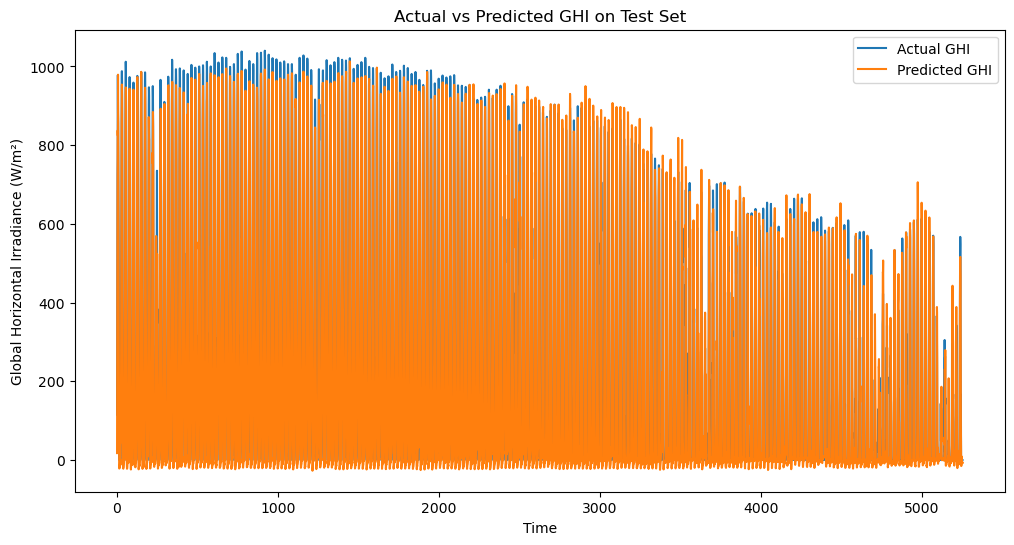

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    # If you're evaluating after training, ensure 'epoch' is set appropriately.
    # For example, if you have completed all training epochs, you might set epoch to epochs-1
    # Alternatively, if evaluation is within the training loop, use the current epoch value.
    evaluation_epoch = epochs - 1  # Adjust based on your training loop structure

    for i, (input, label) in enumerate(test_loader):
        # Obtain the current mode using the scheduler
        # Pass False to indicate evaluation phase
        current_mode = scheduler.mode(evaluation_epoch, i, False)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device)

        # Forward pass with the current mode
        output = net(input, mode=current_mode)

        # Compute the rate as done during training
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        # Inverse transform the predictions and actual values
       
        test_predictions_inv = target_scaler.inverse_transform(rate.reshape(-1, 1))
        test_y_inv = target_scaler.inverse_transform(label.numpy().reshape(-1, 1))

        # Accumulate predictions and labels
        all_predictions.append(test_predictions_inv)
        all_labels.append(test_y_inv)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels, all_predictions))
test_mae = mean_absolute_error(all_labels, all_predictions)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels, label='Actual GHI')
plt.plot(all_predictions, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()


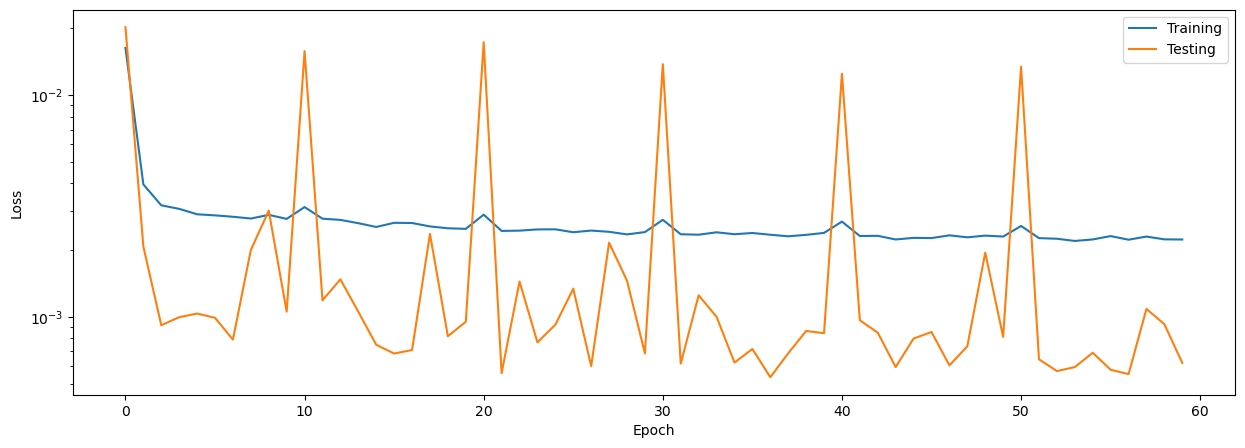

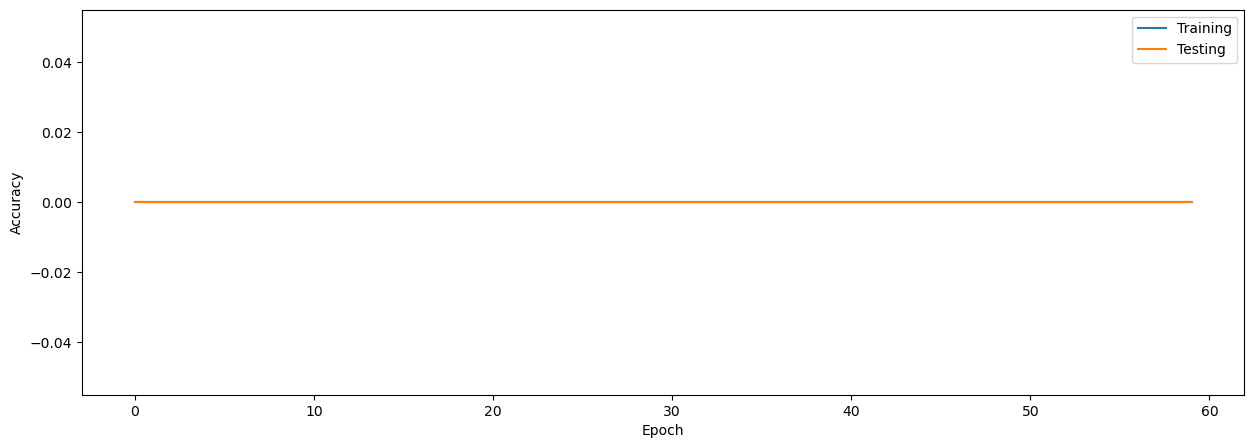

In [6]:
stats.plot(figsize=(15, 5))

In [21]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 1634


In [ ]:
print(net) 

# SNN-CNN-Multivariate-BOOTSTRAP-Network-ANN-SNN-LAVA

In [17]:
# Read the CSV file, parse the 'date' column with the specified format, and set it as the index
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
dataset = read_csv('Palestine-PV.csv',index_col='date')
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
#dataset.info() 
dataset = dataset.astype(np.float64)
dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# load dataset
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
## Reshape for Conv4d
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ))
#train_y = train_y.reshape((train_y.shape[0], 1, 1,1))
#test_y = test_y.reshape((test_y.shape[0], 1, 1,1))
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 0.5,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params,
                 #'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
                 #'dropout' : slayer.neuron.Dropout(p=0.2), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Conv(neuron_params_norm,18,32, kernel_size=1),
                bootstrap.block.cuba.Conv(neuron_params_norm,32,32, kernel_size=1),
                bootstrap.block.cuba.Flatten(),
                bootstrap.block.cuba.Dense(neuron_params_norm, 32, 32),
                bootstrap.block.cuba.Dense(neuron_params_norm,32, 32),
                bootstrap.block.cuba.Affine(neuron_params, 32, 1),
            ])
   
    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
            #print("Input shape:", x.shape)
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        #x = x.reshape(N, -1, x.shape[-1])
      
        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)
        
   
        return x


  # Instantiate Network, Optimizer, DataSet and DataLoader
batch  =64# batch size
lr     = 0.001 # leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs =60 # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones
trained_folder = 'Trained'
logs_folder = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)
#device = torch.device('cuda')
device = torch.device('cpu')
net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # learning rate reduction milestones
# Dataset and dataLoader instances.
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=False)
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader, 0):
        net.train()
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
        loss = F.mse_loss(rate, label)

        #prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        #stats.training.correct_samples += torch.sum( prediction == label ).data.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    event_counts = []
    counts = []
    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))
            # Here we compute the event rate
            
            count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
            mean_count = count.mean(dim=0).tolist()# This line is changed to average over batch dimension
            counts.append(mean_count)

            label = label.view(-1, 1).to(device)  # reshaping the label tensor to have a size of 1 in the second dimension
            loss = F.mse_loss(rate, label)
            #loss = F.mse_loss(rate, label.to(device))
            #prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
        #stats.testing.correct_samples += torch.sum( prediction == label ).data.item()

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Now that we're sure that all entries have the same length, calculate the mean
    counts = np.mean(counts, axis=1)
    #print('Mean Event Rate:', counts)
  
    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_loss:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()

    stats.update()
    stats.save(trained_folder + '/')


[[0.18387909 0.41533546 0.81315346 ... 0.21388889 0.09433962 0.        ]
 [0.17632242 0.41533546 0.82833052 ... 0.25       0.11320755 0.        ]
 [0.17128463 0.41214058 0.83552558 ... 0.275      0.16981132 0.        ]
 ...
 [0.39042821 0.73801917 0.94738617 ... 0.07222222 0.1509434  0.        ]
 [0.38790932 0.73482428 0.94749859 ... 0.09444444 0.11320755 0.        ]
 [0.38539043 0.7284345  0.93715571 ... 0.13333333 0.11320755 0.        ]]
[0.         0.         0.09980989 ... 0.         0.         0.        ]
(21024, 18) (21024,) (5253, 18) (5253,)
torch.Size([21024, 18]) torch.Size([21024]) torch.Size([5253, 18]) torch.Size([5253])
torch.Size([21024, 18, 1, 1])
torch.Size([5253, 18, 1, 1])
torch.Size([21024])
torch.Size([5253])
                                                                                                                                                             
Mode: SNN
[Epoch  0/60]
SNN Testing: loss =     0.04570                          accuracy = 0.00000 
 

#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 58.4864
Test MAE (Unnormalized): 29.5507


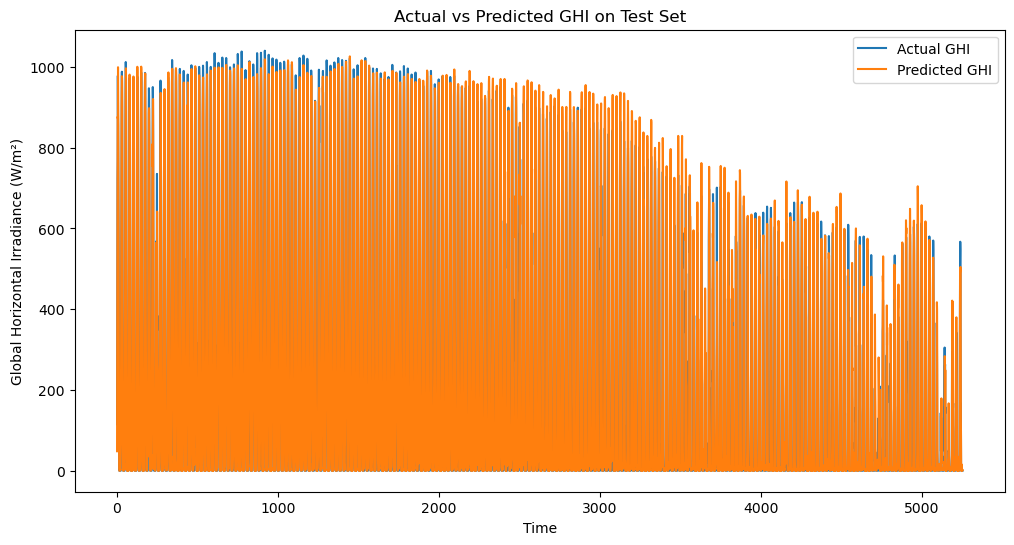

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
net.eval()

all_predictions = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    # If you're evaluating after training, ensure 'epoch' is set appropriately.
    # For example, if you have completed all training epochs, you might set epoch to epochs-1
    # Alternatively, if evaluation is within the training loop, use the current epoch value.
    evaluation_epoch = epochs - 1  # Adjust based on your training loop structure

    for i, (input, label) in enumerate(test_loader):
        # Obtain the current mode using the scheduler
        # Pass False to indicate evaluation phase
        current_mode = scheduler.mode(evaluation_epoch, i, False)

        # Move input and label to the appropriate device
        input = input.to(device)
        label = label.to(device)

        # Forward pass with the current mode
        output = net(input, mode=current_mode)

        # Compute the rate as done during training
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        # Inverse transform the predictions and actual values
       
        test_predictions_inv = target_scaler.inverse_transform(rate.reshape(-1, 1))
        test_y_inv = target_scaler.inverse_transform(label.numpy().reshape(-1, 1))

        # Accumulate predictions and labels
        all_predictions.append(test_predictions_inv)
        all_labels.append(test_y_inv)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(all_labels, all_predictions))
test_mae = mean_absolute_error(all_labels, all_predictions)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(all_labels, label='Actual GHI')
plt.plot(all_predictions, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()


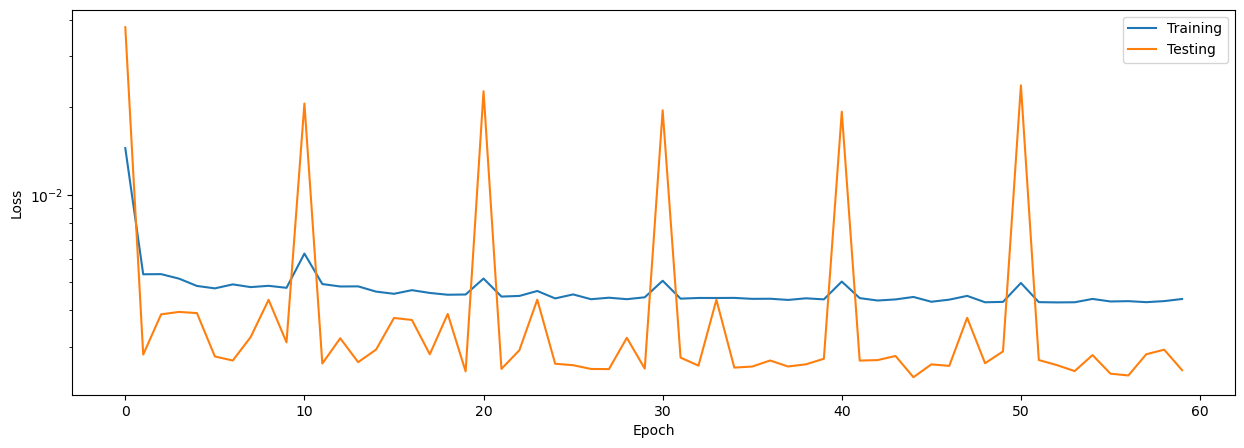

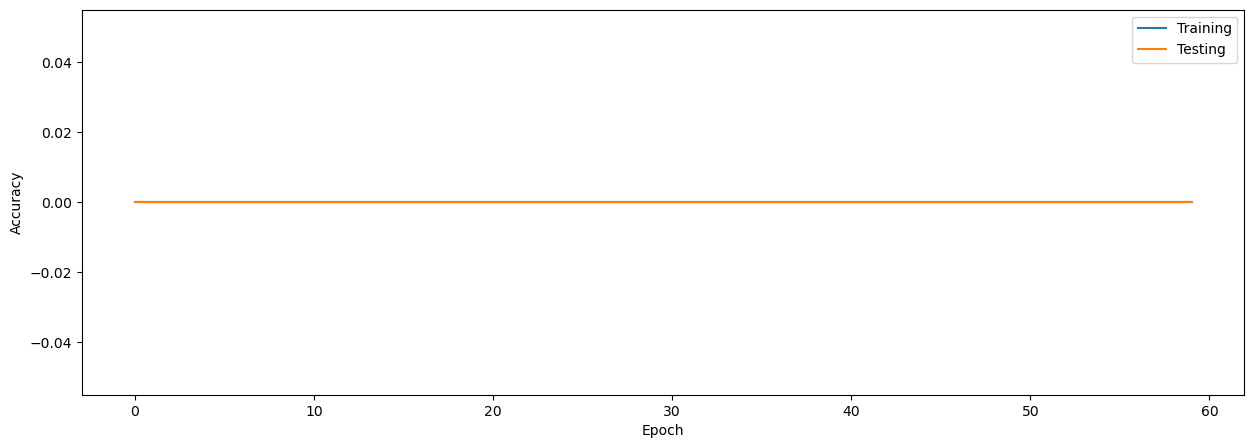

In [29]:
stats.plot(figsize=(15, 5))

In [9]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 3682


In [10]:
print(net)

Network(
  (blocks): ModuleList(
    (0): Input(
      (f): AnnSampler()
      (neuron): Neuron()
    )
    (1): Conv(
      (f): AnnSampler()
      (neuron): Neuron()
      (synapse): Conv(18, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
    (2): Conv(
      (f): AnnSampler()
      (neuron): Neuron()
      (synapse): Conv(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
    (3): Flatten(
      (f): AnnSampler()
    )
    (4-5): 2 x Dense(
      (f): AnnSampler()
      (neuron): Neuron()
      (synapse): Dense(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
    (6): Affine(
      (f): AnnSampler()
      (neuron): Neuron()
      (synapse): Dense(32, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
  )
)


In [11]:
import time

# Start the timer
start_time = time.time()

for epoch in range(epochs):
    # ... existing training code ...

    if scheduler.mode(epoch, 0, net.training).base_mode == bootstrap.routine.Mode.SNN: 
        event_counts = []

        # Adjusted loop: Process only the first 4 batches
        for i, (input, label) in enumerate(test_loader, 0):
            if i >= 7:  # Exit the loop after processing 4 batches
                break

            net.eval()
            mode = scheduler.mode(epoch, i, net.training)

            with torch.no_grad():
                input = input.to(device)
                output = net.forward(input, mode)
                rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

                # Compute the event rate for SNN mode
                count = (output > 0).sum(dim=-1).float()  # Counts the number of positive (firing) events
                mean_count = count.mean(dim=0).tolist()  # Average over batch dimension
                event_counts.append(mean_count)

                # ... existing loss calculation and other code ...

        # Calculate the mean event rate across the first 4 batches
        counts = np.mean(event_counts, axis=1)
        print('Mean Event Rate in SNN Mode:', counts)

    # ... rest of the epoch code ...

    # Stop the timer for each epoch
    end_time = time.time()
    elapsed_time = end_time - start_time
    #print(f"Epoch {epoch} completed in {elapsed_time} seconds.")

# ... existing code for saving the model, updating stats, etc. ...


Mean Event Rate in SNN Mode: [3.859375 3.703125 3.359375 4.078125 3.4375   3.125    3.84375 ]
Mean Event Rate in SNN Mode: [3.859375 3.703125 3.359375 4.078125 3.4375   3.125    3.84375 ]
Mean Event Rate in SNN Mode: [3.859375 3.703125 3.359375 4.078125 3.4375   3.125    3.84375 ]
Mean Event Rate in SNN Mode: [3.859375 3.703125 3.359375 4.078125 3.4375   3.125    3.84375 ]
Mean Event Rate in SNN Mode: [3.859375 3.703125 3.359375 4.078125 3.4375   3.125    3.84375 ]
Mean Event Rate in SNN Mode: [3.859375 3.703125 3.359375 4.078125 3.4375   3.125    3.84375 ]


In [12]:
import importlib.util

spec = importlib.util.spec_from_file_location("desired_utils", "D:/Profiles/anaconda/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py")
desired_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(desired_utils)

# Now you can use desired_utils as the module
#desired_utils.compare_ops()

In [13]:
#utils.compare_ops(net, counts, mse=stats.testing.min_loss)
print(f"Length of counts: {len(counts)}")
print(f"Number of layers in net.blocks: {len(net.blocks)}")

desired_utils.compare_ops(net, counts, mse=stats.testing.min_loss)

Length of counts: 7
Number of layers in net.blocks: 7
|-----------------------------------------------------------------------------|
|                         |          SDNN           |           ANN           |
|-----------------------------------------------------------------------------|
|         |     Shape     |  Events  |    Synops    | Activations|    MACs    |
|-----------------------------------------------------------------------------|
| layer-0 | (  1,  1, 18) |     3.86 |              |         18 |            |
| layer-1 | (  1,  1, 32) |     3.70 |       123.50 |         32 |        576 |
| layer-2 | (  1,  1, 32) |     3.36 |       118.50 |         32 |       1024 |
| layer-3 | (  1,  1, 32) |     4.08 |       107.50 |         32 |       1024 |
| layer-4 | (  1,  1, 32) |     3.44 |       130.50 |         32 |       1024 |
| layer-5 | (  1,  1,  1) |     3.12 |         3.44 |          1 |         32 |
| layer-6 | 

IndexError: list index out of range

In [12]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 3682
